# Momentum strategy

  - [x] выбираем эмитента по критериям: существует на рынке в настоящий момент, капитализация более 100 млрд. руб.
  - [x] скачиваем данные, сохраняем в sqlite
  - [ ] ищем winners и losers по квантилям на временном горизонте (как глобальная переменная):
    - 1 месяц
    - 6 месяцев
    - 12 месяцев 
  - [х] определяем начало и окончание бэктеста как глобальные переменные
  - [ ] переопределяем портфель 1 раз в месяц или 1 раз в квартал

In [214]:
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.2f}'.format

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

import datetime as dt
import pandas_datareader.data as reader
from dateutil.relativedelta import relativedelta

import sqlalchemy
import yfinance as yf

In [148]:
CAPI_THRESHOLD = 10E+10
START = dt.datetime(2016, 6, 30)
END = dt.datetime(2021, 6, 30)

## Reading data

In [152]:
stocks = pd.read_html("https://www.moex.com/a7714", flavor='html5lib')[0]
stocks.head()

,Торговый код ценной бумаги,Краткое наименование эмитента ценной бумаги,"Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)",Государственный регистрационный номер выпуска (дополнительного выпуска)*,"Объем выпуска, штук","Рыночная цена (3) на 31.03.2021, руб.","Капитализация, руб."
0,ABRD,"ПАО ""Абрау – Дюрсо""",aо,1-02-12500-A,98 000 184,2125.00,"20 825 039 100,00"
1,ACKO,"ПАО ""АСКО-СТРАХОВАНИЕ""",aо,1-01-52065-Z,536 000 000,638.00,"3 419 680 000,00"
2,AFKS,"ПАО АФК ""Система""",aо,1-05-01669-A,9 650 000 000,34178.00,"329 817 700 000,00"
3,AFLT,"ПАО ""Аэрофлот-российские авиалинии""",aо,1-01-00010-A,2 444 535 448,6724.00,"164 370 563 523,52"
4,AKRN,"ПАО ""Акрон""",aо,1-03-00207-A,40 534 000,6204.00,"251 472 936 000,00"


In [153]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Торговый код ценной бумаги                                                       261 non-null    object 
 1   Краткое наименование эмитента ценной бумаги                                      261 non-null    object 
 2   Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)  261 non-null    object 
 3   Государственный  регистрационный  номер выпуска  (дополнительного  выпуска)*     261 non-null    object 
 4   Объем выпуска, штук                                                              261 non-null    object 
 5   Рыночная цена (3) на 31.03.2021, руб.                                            246 non-null    float64
 6   Капитализац

In [154]:
stocks['Капитализация, руб.'] = stocks['Капитализация, руб.'].str.replace(' ', '')
stocks['Капитализация, руб.'] = stocks['Капитализация, руб.'].str.replace(',', '.')
stocks['Капитализация, руб.'] = stocks['Капитализация, руб.'].astype('float')

# добавим .ME к названию тикера, чтобы Yahoo корректно отвечал
stocks['Торговый код ценной бумаги Yahoo'] = stocks['Торговый код ценной бумаги'] + '.ME'

stocks.head()

,Торговый код ценной бумаги,Краткое наименование эмитента ценной бумаги,"Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)",Государственный регистрационный номер выпуска (дополнительного выпуска)*,"Объем выпуска, штук","Рыночная цена (3) на 31.03.2021, руб.","Капитализация, руб.",Торговый код ценной бумаги Yahoo
0,ABRD,"ПАО ""Абрау – Дюрсо""",aо,1-02-12500-A,98 000 184,2125.00,20825039100.00,ABRD.ME
1,ACKO,"ПАО ""АСКО-СТРАХОВАНИЕ""",aо,1-01-52065-Z,536 000 000,638.00,3419680000.00,ACKO.ME
2,AFKS,"ПАО АФК ""Система""",aо,1-05-01669-A,9 650 000 000,34178.00,329817700000.00,AFKS.ME
3,AFLT,"ПАО ""Аэрофлот-российские авиалинии""",aо,1-01-00010-A,2 444 535 448,6724.00,164370563523.52,AFLT.ME
4,AKRN,"ПАО ""Акрон""",aо,1-03-00207-A,40 534 000,6204.00,251472936000.00,AKRN.ME


In [156]:
# slicing by capitalization

tickers = stocks[stocks['Капитализация, руб.'] > CAPI_THRESHOLD]['Торговый код ценной бумаги Yahoo']
tickers

2       AFKS.ME
3       AFLT.ME
4       AKRN.ME
7       ALRS.ME
9       APTK.ME
14      BANE.ME
23      CBOM.ME
27      CHMF.ME
34      DSKY.ME
40      ENPG.ME
42      FEES.ME
44      FLOT.ME
48      GAZP.ME
51      GCHE.ME
53      GMKN.ME
61      HYDR.ME
66      IRAO.ME
99      KZOS.ME
102     LKOH.ME
112     MAGN.ME
116     MGNT.ME
118     MGTS.ME
122     MOEX.ME
139     MTSS.ME
140     MVID.ME
144     NKNC.ME
147     NLMK.ME
148     NMTP.ME
153     NVTK.ME
159     PHOR.ME
160     PIKK.ME
161     PLZL.ME
164     POGR.ME
165     POLY.ME
168     RASP.ME
172     RGSS.ME
178     ROSB.ME
179     ROSN.ME
181     RSTI.ME
184     RTKM.ME
188     RUAL.ME
196     SBER.ME
197    SBERP.ME
202     SIBN.ME
205     SNGS.ME
206    SNGSP.ME
213     TATN.ME
226    TRNFP.ME
232     UNAC.ME
234     UPRO.ME
246     VSMO.ME
249     VTBR.ME
253     YAKG.ME
256     YNDX.ME
Name: Торговый код ценной бумаги Yahoo, dtype: object

Получаем данные для необходимых тикеров:

In [157]:
def getdata(tickers):
    """get yahoo finance data for selected tickers"""
    data = []
    for ticker in tickers:
        data.append(yf.download(ticker).reset_index())
    print('Successfully downloaded!')
    return data

In [158]:
prices = getdata(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Создаем движок:

In [163]:
def createengine(name):
    engine = sqlalchemy.create_engine('sqlite:///' + name)
    print('Engine is created!')
    return engine

In [164]:
MOEXengine = createengine('MOEX')

Engine is created!


Создаем базу (без схемы):

In [165]:
def transfer_SQL(frames, symbols, engine):
    """created tables of each ticker into the database"""
    for frame, symbol in zip(frames, symbols):
        frame.to_sql(symbol, engine, index=False)
    print('Succesfully imported!')

In [166]:
transfer_SQL(prices, tickers, MOEXengine)

Succesfully imported!


Тестовый запрос:

In [169]:
my_query = '''SELECT * FROM YNDX'''
pd.read_sql(my_query, MOEXengine)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-06-04 00:00:00.000000,1546.70,1546.80,1163.00,1170.00,1170.00,35146
1,2014-06-05 00:00:00.000000,1187.30,1195.00,1141.10,1145.10,1145.10,25038
2,2014-06-06 00:00:00.000000,1158.30,1173.50,1151.00,1163.00,1163.00,7889
3,2014-06-09 00:00:00.000000,1178.90,1185.60,1155.70,1172.10,1172.10,7304
4,2014-06-10 00:00:00.000000,1178.90,1181.00,1160.10,1170.00,1170.00,3216
...,...,...,...,...,...,...,...
1783,2021-07-14 00:00:00.000000,5240.20,5278.80,5187.60,5201.80,5201.80,315886
1784,2021-07-15 00:00:00.000000,5176.80,5238.80,5140.00,5188.20,5188.20,289434
1785,2021-07-16 00:00:00.000000,5188.00,5235.00,5137.80,5168.60,5168.60,307147
1786,2021-07-19 00:00:00.000000,5150.00,5179.00,5059.80,5087.80,5087.80,510104


## Build a strategy using adjusted closing price
[adjusted closing price](https://www.investopedia.com/terms/a/adjusted_closing_price.asp)

In [199]:
df = reader.get_data_yahoo(tickers.to_list(), START, END)['Adj Close']
df

C:\Users\Slava\anaconda3\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'POGR.ME', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


Symbols,AFKS.ME,AFLT.ME,AKRN.ME,ALRS.ME,APTK.ME,BANE.ME,CBOM.ME,CHMF.ME,DSKY.ME,ENPG.ME,FEES.ME,FLOT.ME,GAZP.ME,GCHE.ME,GMKN.ME,HYDR.ME,IRAO.ME,KZOS.ME,LKOH.ME,MAGN.ME,MGNT.ME,MGTS.ME,MOEX.ME,MTSS.ME,MVID.ME,NKNC.ME,NLMK.ME,NMTP.ME,NVTK.ME,PHOR.ME,PIKK.ME,PLZL.ME,POLY.ME,RASP.ME,RGSS.ME,ROSB.ME,ROSN.ME,RSTI.ME,RTKM.ME,RUAL.ME,SBER.ME,SBERP.ME,SIBN.ME,SNGS.ME,SNGSP.ME,TATN.ME,TRNFP.ME,UNAC.ME,UPRO.ME,VSMO.ME,VTBR.ME,YAKG.ME,YNDX.ME,POGR.ME
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-30,16.51,72.55,2404.32,39.00,9.89,2085.08,3.91,360.89,nan,nan,0.09,nan,95.70,653.03,5316.08,0.44,2.09,26.68,1814.58,15.23,6472.84,531.85,80.13,121.94,258.42,33.88,45.06,2.41,574.95,1905.30,202.55,3665.94,880.25,25.95,0.35,44.00,270.16,0.53,60.65,20.21,80.12,51.54,115.17,29.23,20.40,193.97,123277.05,0.52,1.68,7387.93,0.05,18.48,1399.00,nan
2016-07-01,17.23,72.98,2359.61,38.55,9.90,2064.08,3.92,375.34,nan,nan,0.10,nan,96.07,650.76,5288.69,0.45,2.04,26.61,1830.13,15.38,6536.77,527.13,80.07,122.94,256.36,33.68,45.44,2.47,571.94,1894.94,201.98,3654.23,884.73,26.78,0.36,42.80,272.17,0.53,60.19,20.14,80.63,52.00,116.49,29.01,20.51,193.97,123277.05,0.53,1.71,7369.25,0.06,17.53,1403.00,nan
2016-07-04,17.18,72.27,2383.68,39.11,9.93,2070.85,3.93,367.29,nan,nan,0.10,nan,97.13,648.48,5515.90,0.45,2.02,26.47,1855.82,15.51,6568.37,536.05,80.40,125.29,256.79,34.13,45.67,2.43,569.54,1878.35,202.39,3654.23,916.12,27.53,0.36,44.00,271.14,0.53,60.49,21.17,81.08,51.96,115.74,29.09,20.73,191.52,122462.59,0.53,1.71,7369.25,0.06,15.63,1390.00,nan
2016-07-05,17.44,73.38,2376.80,39.17,9.97,2072.63,3.90,371.42,nan,nan,0.10,nan,96.68,653.03,5483.53,0.44,2.11,26.39,1872.38,15.04,6428.31,537.10,78.89,125.13,254.14,34.26,44.59,2.52,562.97,1830.66,202.55,3666.72,909.14,26.23,0.35,44.90,269.67,0.57,60.46,20.96,79.43,50.97,117.02,28.96,21.01,188.41,120907.75,0.53,1.71,7356.79,0.05,15.63,1383.00,nan
2016-07-06,17.13,73.36,2373.36,38.67,10.02,2026.72,3.89,376.36,nan,nan,0.10,nan,96.03,651.51,5460.50,0.44,2.10,26.97,1847.03,15.73,6291.85,535.00,79.05,125.16,251.40,34.45,45.68,2.46,561.10,1782.98,201.66,3661.26,945.51,25.71,0.35,45.10,262.38,0.61,60.53,20.76,77.93,50.54,115.84,28.29,21.17,187.92,120389.47,0.52,1.74,7350.56,0.06,13.74,1372.00,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24,30.57,69.14,5948.00,123.41,13.59,1503.00,6.43,1590.80,142.68,855.00,0.21,86.92,265.09,2241.50,24434.00,0.80,4.82,88.40,6542.18,61.51,5329.00,2185.00,174.83,313.78,624.90,104.15,236.78,6.93,1509.80,4720.76,1097.70,14408.50,1626.60,229.42,0.23,78.00,566.50,1.32,96.89,52.44,310.47,286.64,430.65,37.18,39.33,524.87,162898.27,0.60,2.81,28200.00,0.05,102.85,5066.20,nan
2021-06-25,30.52,70.16,5960.00,122.96,13.51,1497.00,6.45,1567.00,142.61,840.50,0.21,87.06,265.40,2227.00,24724.00,0.81,4.85,88.80,6575.14,59.71,5331.00,2185.00,172.36,316.04,619.10,103.10,231.62,6.93,1548.00,4730.54,1113.20,14311.00,1624.80,224.82,0.22,78.80,563.35,1.32,97.34,50.89,311.80,287.12,430.05,36.79,39.59,524.97,163940.67,0.60,2.81,28080.00,0.05,103.30,5080.00,nan
2021-06-28,30.51,69.30,5950.00,123.80,13.53,1495.00,6.50,1572.00,144.68,825.00,0.21,86.61,265.65,2246.00,24936.00,0.81,4.81,89.40,6556.72,60.08,5314.50,2170.00,174.15,316.14,615.00,105.15,231.70,6.92,1541.20,4711.95,1107.30,14338.50,1625.00,219.58,0.22,78.00,554.90,1.32,97.02,48.94,309.57,284.69,429.65,36.41,39.58,518.81,164272.34,0.58,2.80,28080.00,0.05,103.30,5084.80,nan


In [200]:
df.isna().sum()

Symbols
AFKS.ME        0
AFLT.ME        0
AKRN.ME        0
ALRS.ME        0
APTK.ME        0
BANE.ME        0
CBOM.ME        0
CHMF.ME        0
DSKY.ME      159
ENPG.ME      918
FEES.ME        0
FLOT.ME     1076
GAZP.ME        0
GCHE.ME        0
GMKN.ME        0
HYDR.ME        0
IRAO.ME        0
KZOS.ME        0
LKOH.ME        0
MAGN.ME        0
MGNT.ME        0
MGTS.ME        0
MOEX.ME        0
MTSS.ME        0
MVID.ME        0
NKNC.ME        0
NLMK.ME        0
NMTP.ME        0
NVTK.ME        0
PHOR.ME        0
PIKK.ME        0
PLZL.ME        0
POLY.ME        0
RASP.ME        0
RGSS.ME        0
ROSB.ME        0
ROSN.ME        0
RSTI.ME        0
RTKM.ME        0
RUAL.ME        0
SBER.ME        0
SBERP.ME       0
SIBN.ME        0
SNGS.ME        0
SNGSP.ME       0
TATN.ME        0
TRNFP.ME       0
UNAC.ME        0
UPRO.ME        0
VSMO.ME        0
VTBR.ME        0
YAKG.ME        0
YNDX.ME        0
POGR.ME     1259
dtype: int64

In [201]:
df = df.drop(['DSKY.ME', 'ENPG.ME', 'FLOT.ME', 'POGR.ME'], axis=1)

В академических работах отмечается, что на многомесячном тренде роста иногда возникает обратное контр-трендовое движение, длительностью до месяца. Чтобы отсечь этот «противоход», часто используют определение моментума в следующем виде: общий рост за N месяцев, без учета последнего(самого недавнего) месяца. В модели Фамы-Френча используется определение моментума — 12 минус 1, т.е. рост за 12 месяцев, без учета последнего месяца.

In [204]:
# Calculate monthly return by cumulating daily returns (skip last month)

mtl_ret = df.pct_change().resample('M').agg(lambda x:(x+1).prod()-1)
mtl_ret

Symbols,AFKS.ME,AFLT.ME,AKRN.ME,ALRS.ME,APTK.ME,BANE.ME,CBOM.ME,CHMF.ME,FEES.ME,GAZP.ME,GCHE.ME,GMKN.ME,HYDR.ME,IRAO.ME,KZOS.ME,LKOH.ME,MAGN.ME,MGNT.ME,MGTS.ME,MOEX.ME,MTSS.ME,MVID.ME,NKNC.ME,NLMK.ME,NMTP.ME,NVTK.ME,PHOR.ME,PIKK.ME,PLZL.ME,POLY.ME,RASP.ME,RGSS.ME,ROSB.ME,ROSN.ME,RSTI.ME,RTKM.ME,RUAL.ME,SBER.ME,SBERP.ME,SIBN.ME,SNGS.ME,SNGSP.ME,TATN.ME,TRNFP.ME,UNAC.ME,UPRO.ME,VSMO.ME,VTBR.ME,YAKG.ME,YNDX.ME
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-07-31,0.16,0.00,-0.02,0.06,0.03,0.05,0.00,0.18,0.12,0.04,0.01,0.11,0.23,0.04,0.06,0.11,0.23,0.13,0.08,0.01,0.10,0.07,0.07,0.15,0.06,0.00,-0.02,-0.00,-0.01,0.10,0.16,0.02,0.00,-0.01,0.43,-0.01,0.14,0.05,0.10,0.03,-0.04,0.02,-0.01,0.01,-0.05,0.18,0.05,0.01,-0.18,0.03
2016-08-31,-0.02,0.15,0.07,0.06,-0.02,0.09,0.04,-0.05,0.09,-0.02,-0.04,0.01,0.13,0.09,0.08,0.02,0.03,0.01,-0.12,0.12,-0.05,0.08,0.13,-0.06,0.17,0.06,-0.02,0.09,-0.01,-0.06,0.20,-0.02,0.08,0.06,0.07,-0.04,0.05,0.03,0.03,0.04,-0.00,0.00,0.00,-0.07,0.04,-0.06,0.10,0.02,0.00,-0.01
2016-09-30,-0.11,0.19,-0.04,0.15,-0.06,-0.01,0.03,0.03,0.02,-0.00,-0.06,0.03,-0.03,0.12,-0.01,0.05,-0.06,0.02,-0.05,-0.00,-0.05,-0.01,0.04,-0.08,0.14,-0.00,-0.04,0.07,-0.02,-0.13,0.36,0.03,0.04,-0.01,-0.00,-0.04,-0.09,0.01,0.04,0.03,-0.02,-0.11,0.01,-0.13,-0.03,0.02,0.03,0.05,-0.01,-0.06
2016-10-31,-0.03,0.11,-0.11,0.02,0.01,0.06,0.01,0.18,-0.04,0.03,-0.05,-0.05,0.03,0.07,-0.00,0.01,0.14,0.02,0.01,-0.08,0.04,-0.01,0.11,0.25,0.28,-0.02,-0.04,-0.02,-0.02,-0.14,0.28,0.00,0.06,0.01,0.05,0.00,0.06,0.01,0.05,0.04,-0.12,-0.01,0.11,0.13,0.02,0.01,-0.03,-0.06,-0.04,-0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,0.10,-0.01,-0.02,0.00,-0.00,-0.01,0.09,0.07,0.00,0.02,0.07,-0.04,0.00,-0.03,-0.05,0.04,0.05,-0.00,-0.02,0.10,-0.05,0.13,0.00,0.06,-0.03,0.01,0.11,0.10,-0.02,-0.09,0.09,0.04,-0.01,0.11,0.06,0.07,0.12,0.04,0.05,0.11,-0.03,-0.02,0.07,-0.00,0.09,-0.01,0.07,0.01,0.20,0.01
2021-03-31,-0.01,-0.03,0.03,0.06,0.06,0.01,0.06,0.15,0.01,0.04,0.17,0.01,0.04,0.01,0.11,0.10,0.12,0.09,0.03,0.01,0.00,-0.12,-0.03,0.09,-0.05,0.17,0.01,0.20,-0.00,-0.00,0.04,-0.04,0.02,0.09,-0.11,-0.01,0.27,0.08,0.09,0.06,0.06,0.07,0.14,0.03,0.02,0.05,0.15,0.15,0.66,0.01
2021-04-30,-0.01,-0.05,-0.04,0.03,-0.02,-0.04,-0.04,0.16,-0.02,0.01,-0.08,0.09,0.01,-0.04,0.06,-0.05,0.08,-0.04,-0.02,0.02,0.02,-0.06,0.10,0.10,-0.03,-0.09,0.08,-0.01,-0.00,0.05,0.26,-0.01,-0.01,-0.08,-0.05,-0.03,0.02,0.02,0.05,-0.02,-0.01,0.02,-0.15,-0.04,0.14,-0.03,-0.10,0.21,-0.07,0.01


In [205]:
# Calculate returns over the past 11 months (skip last month)

past_11 = (mtl_ret+1).rolling(11).apply(np.prod)-1
past_11

Symbols,AFKS.ME,AFLT.ME,AKRN.ME,ALRS.ME,APTK.ME,BANE.ME,CBOM.ME,CHMF.ME,FEES.ME,GAZP.ME,GCHE.ME,GMKN.ME,HYDR.ME,IRAO.ME,KZOS.ME,LKOH.ME,MAGN.ME,MGNT.ME,MGTS.ME,MOEX.ME,MTSS.ME,MVID.ME,NKNC.ME,NLMK.ME,NMTP.ME,NVTK.ME,PHOR.ME,PIKK.ME,PLZL.ME,POLY.ME,RASP.ME,RGSS.ME,ROSB.ME,ROSN.ME,RSTI.ME,RTKM.ME,RUAL.ME,SBER.ME,SBERP.ME,SIBN.ME,SNGS.ME,SNGSP.ME,TATN.ME,TRNFP.ME,UNAC.ME,UPRO.ME,VSMO.ME,VTBR.ME,YAKG.ME,YNDX.ME
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2016-07-31,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2016-08-31,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2016-09-30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2016-10-31,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,1.67,0.25,0.08,0.60,-0.03,0.12,0.22,0.73,0.40,0.31,0.18,0.26,0.35,0.08,0.05,0.28,0.55,0.67,-0.09,0.89,0.15,1.20,0.13,1.07,0.06,0.44,0.77,0.97,0.36,0.10,0.95,0.85,0.26,0.75,0.53,0.54,0.55,0.91,0.91,0.23,-0.02,0.08,0.09,0.05,-0.01,0.23,0.21,0.16,0.40,0.78
2021-03-31,1.40,0.09,0.13,0.77,0.03,-0.01,0.30,0.93,0.24,0.30,0.50,0.22,0.36,0.07,0.04,0.37,0.66,0.57,-0.12,0.54,0.08,1.09,-0.01,1.18,0.01,0.48,0.64,1.46,0.18,-0.03,0.86,0.67,0.13,0.78,0.25,0.38,0.88,0.96,1.07,0.19,-0.05,0.19,0.25,0.17,-0.10,0.19,0.45,0.25,1.83,0.72
2021-04-30,1.23,0.01,0.02,0.72,0.04,-0.09,0.26,1.12,0.16,0.25,0.36,0.20,0.25,-0.00,0.12,0.20,0.78,0.49,-0.12,0.55,0.10,1.09,0.07,1.13,-0.11,0.34,0.71,1.52,0.22,0.10,1.32,0.66,0.12,0.46,-0.08,0.32,0.82,0.78,0.89,0.17,-0.12,0.25,0.10,0.19,0.11,0.18,0.27,0.45,1.86,0.75


In [206]:
formation = dt.datetime(2021, 5, 31)

end_measurment = formation - relativedelta(months=1)
print(formation, end_measurment)

2021-05-31 00:00:00 2021-04-30 00:00:00


In [207]:
ret_12 = past_11.loc[end_measurment]
ret_12 = ret_12.reset_index()
ret_12.columns = ['ticker', 'returns']
ret_12

,ticker,returns
0,AFKS.ME,1.23
1,AFLT.ME,0.01
2,AKRN.ME,0.02
3,ALRS.ME,0.72
4,APTK.ME,0.04
5,BANE.ME,-0.09
6,CBOM.ME,0.26
7,CHMF.ME,1.12
8,FEES.ME,0.16
9,GAZP.ME,0.25


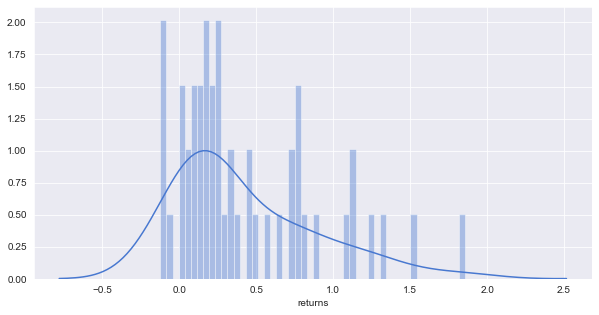

In [215]:
sns.distplot(ret_12['returns'], bins=50)

In [216]:
# find winners and losers
ret_12['quintile'] = pd.qcut(ret_12.iloc[:,1], 5, labels=False)
ret_12

,ticker,returns,quintile
0,AFKS.ME,1.23,4
1,AFLT.ME,0.01,0
2,AKRN.ME,0.02,0
3,ALRS.ME,0.72,3
4,APTK.ME,0.04,0
5,BANE.ME,-0.09,0
6,CBOM.ME,0.26,2
7,CHMF.ME,1.12,4
8,FEES.ME,0.16,1
9,GAZP.ME,0.25,2


In [217]:
winners = ret_12[ret_12.quintile == 4]
winners

,ticker,returns,quintile
0,AFKS.ME,1.23,4
7,CHMF.ME,1.12,4
16,MAGN.ME,0.78,4
21,MVID.ME,1.09,4
23,NLMK.ME,1.13,4
27,PIKK.ME,1.52,4
30,RASP.ME,1.32,4
36,RUAL.ME,0.82,4
38,SBERP.ME,0.89,4
48,YAKG.ME,1.86,4


In [218]:
losers = ret_12[ret_12.quintile == 0]
losers

,ticker,returns,quintile
1,AFLT.ME,0.01,0
2,AKRN.ME,0.02,0
4,APTK.ME,0.04,0
5,BANE.ME,-0.09,0
13,IRAO.ME,-0.00,0
18,MGTS.ME,-0.12,0
22,NKNC.ME,0.07,0
24,NMTP.ME,-0.11,0
34,RSTI.ME,-0.08,0
40,SNGS.ME,-0.12,0


In [220]:
winnerret = mtl_ret.loc[formation + relativedelta(months=1), 
                       df.columns.isin(winners.ticker)]

loserret = mtl_ret.loc[formation + relativedelta(months=1), 
                       df.columns.isin(losers.ticker)]

winnerret

Symbols
AFKS.ME     0.00
CHMF.ME    -0.07
MAGN.ME     0.00
MVID.ME    -0.09
NLMK.ME    -0.09
PIKK.ME     0.05
RASP.ME    -0.14
RUAL.ME    -0.14
SBERP.ME   -0.04
YAKG.ME    -0.06
Name: 2021-06-30 00:00:00, dtype: float64

In [221]:
loserret

Symbols
AFLT.ME   -0.02
AKRN.ME   -0.00
APTK.ME    0.02
BANE.ME   -0.03
IRAO.ME   -0.04
MGTS.ME   -0.01
NKNC.ME    0.11
NMTP.ME   -0.04
RSTI.ME   -0.04
SNGS.ME    0.01
Name: 2021-06-30 00:00:00, dtype: float64

In [222]:
Momentumprofit = winnerret.mean() - loserret.mean()
Momentumprofit

-0.05134293722178852

In [223]:
MOEX = reader.get_data_yahoo('IMOEX.ME', START, END)['Adj Close'].pct_change().resample('M').agg(lambda x: (x+1).prod() -1)

MOEX

Date
2016-06-30   0.00
2016-07-31   0.03
2016-08-31   0.01
2016-09-30   0.00
2016-10-31   0.01
             ... 
2021-02-28   0.02
2021-03-31   0.06
2021-04-30   0.00
2021-05-31   0.05
2021-06-30   0.03
Freq: M, Name: Adj Close, Length: 61, dtype: float64

TODO: написать выводы, попробовать интервал в два года

In [175]:
#NOTES

# можно получить данные с ММВБ
reader.get_data_moex('GAZP', '2021-07-10', '2021-07-20')

# полезные методы https://pypi.org/project/yfinance/
sber = yf.Ticker("SBER.ME")
sber.dividends
sber.earnings

Date
2012-04-11    2.08
2013-04-12    2.57
2014-06-16    3.20
2015-06-11    0.45
2016-06-10    1.97
2017-06-09    6.00
2018-06-25   12.00
2019-06-11   16.00
2020-05-13   18.70
2020-07-15   18.70
2020-10-02   18.70
2021-05-11   18.70
Name: Dividends, dtype: float64